# Baseline Models

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import average_precision_score, RocCurveDisplay, roc_curve
from sklearn import metrics

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.pipeline import Pipeline

In [33]:
data = pd.read_csv('../data/data_items.csv')

In [36]:
# Drop irrelevant columns
y = data['bank_status']
X = data.drop(columns = ['cik', 'sic', 'sic_description', 'filedate', 'accession_num',
       'primary_doc', 'filelink', 'bank_status', 'item_1A', 'item_2', 'item_7'])

In [37]:
# Create dummy variables for industry and year
X_with_dummies = pd.get_dummies(X, columns = ['main_industry', 'year'])

In [38]:
# Split training and testing data
X_train, X_test, y_train, y_test = train_test_split(X_with_dummies, y, test_size = 0.25, random_state = 42)

In [40]:
# Standardization
scaler = StandardScaler().fit(X_train.iloc[:, 0:23])
scaled_terms_train = pd.DataFrame(scaler.transform(X_train.iloc[:, 0:23]), columns = X_train.columns[0:23])
X_train_scaled = pd.concat([scaled_terms_train, X_train.iloc[:,23:].reset_index(drop = True)], axis = 1)
scaled_terms_test = pd.DataFrame(scaler.transform(X_test.iloc[:, 0:23]), columns = X_test.columns[0:23])
X_test_scaled = pd.concat([scaled_terms_test, X_test.iloc[:,23:].reset_index(drop = True)], axis = 1)

In [41]:
def measure(clf):
    y_pred_test = clf.predict(X_test_scaled)
    y_pred_prob_test = clf.predict_proba(X_test_scaled)[:,1]
    y_pred_train = clf.predict(X_train_scaled)
    y_pred_prob_train = clf.predict_proba(X_train_scaled)[:,1]

    print(classification_report(y_train, y_pred_train))
    print("Train Auc_roc:", roc_auc_score(y_train, y_pred_prob_train))
    print("Train average precision:", average_precision_score(y_train, y_pred_prob_train))

    print(classification_report(y_test, y_pred_test))
    print("Test auc_roc:", roc_auc_score(y_test, y_pred_prob_test))
    print("Test average precision:", average_precision_score(y_test, y_pred_prob_test))

# 1. Logistic Regression

## 1.1. vanilla

In [42]:
vlr = LogisticRegression(max_iter = 1000, fit_intercept = False)
vlr.fit(X_train_scaled, y_train)
measure(vlr)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      7238
           1       1.00      0.02      0.04        45

    accuracy                           0.99      7283
   macro avg       1.00      0.51      0.52      7283
weighted avg       0.99      0.99      0.99      7283

Train Auc_roc: 0.899415123883209
Train average precision: 0.12198836507908903
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2405
           1       0.00      0.00      0.00        23

    accuracy                           0.99      2428
   macro avg       0.50      0.50      0.50      2428
weighted avg       0.98      0.99      0.99      2428

Test auc_roc: 0.8386875169483865
Test average precision: 0.05918683295994269


## 1.2. Weighted data

In [43]:
wlr = LogisticRegression(max_iter = 1000, fit_intercept = False, class_weight='balanced')
wlr.fit(X_train_scaled, y_train)
measure(wlr)

              precision    recall  f1-score   support

           0       1.00      0.87      0.93      7238
           1       0.04      0.93      0.08        45

    accuracy                           0.87      7283
   macro avg       0.52      0.90      0.50      7283
weighted avg       0.99      0.87      0.92      7283

Train Auc_roc: 0.9432240336495656
Train average precision: 0.07052612414532425
              precision    recall  f1-score   support

           0       1.00      0.86      0.92      2405
           1       0.04      0.57      0.07        23

    accuracy                           0.86      2428
   macro avg       0.52      0.71      0.50      2428
weighted avg       0.99      0.86      0.92      2428

Test auc_roc: 0.8764711199493808
Test average precision: 0.07541017924456514


## 1.3. SMOTE + Logistic Regression

In [44]:
model = LogisticRegression(max_iter = 1000, fit_intercept = False)
under = RandomUnderSampler(sampling_strategy = 0.9, random_state = 42)
over = SMOTE(sampling_strategy = 0.5, random_state = 42)
steps = [('over', over), ('under', under), ('model', model)]
smote_lr = Pipeline(steps = steps)
smote_lr.fit(X_train_scaled, y_train)

Pipeline(steps=[('over', SMOTE(random_state=42, sampling_strategy=0.5)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.9)),
                ('model',
                 LogisticRegression(fit_intercept=False, max_iter=1000))])

In [45]:
measure(smote_lr)

              precision    recall  f1-score   support

           0       1.00      0.86      0.93      7238
           1       0.04      0.87      0.07        45

    accuracy                           0.86      7283
   macro avg       0.52      0.87      0.50      7283
weighted avg       0.99      0.86      0.92      7283

Train Auc_roc: 0.9321743268551779
Train average precision: 0.08514420055792328
              precision    recall  f1-score   support

           0       1.00      0.86      0.92      2405
           1       0.04      0.57      0.07        23

    accuracy                           0.86      2428
   macro avg       0.52      0.71      0.50      2428
weighted avg       0.99      0.86      0.91      2428

Test auc_roc: 0.8569104221278134
Test average precision: 0.07590958748209238


# 2. Decision Tree

In [46]:
parameters = {
    'max_depth': [10, 15, 20, 25, 30], 
    'min_samples_leaf': [5, 10, 20, 30], 
    'max_features': ['sqrt', 'log2'], 
    'ccp_alpha': [0.01, 0.001, 0.0001, 0.00001]
}
vanilla_tree = GridSearchCV(
            estimator = tree.DecisionTreeClassifier(random_state = 42),
            param_grid = parameters,
            scoring = 'average_precision',
            cv = 5)
vanilla_tree.fit(X_train_scaled, y_train)

grid_search = GridSearchCV(
            estimator = tree.DecisionTreeClassifier(class_weight = 'balanced', random_state = 42),
            param_grid = parameters,
            scoring = 'average_precision',
            cv = 5)
grid_search.fit(X_train_scaled, y_train)

print("Best parameters for vanilla tree:", vanilla_tree.best_params_)
print("Best parameters:", grid_search.best_params_)

Best parameters for vanilla tree: {'ccp_alpha': 0.0001, 'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 10}
Best parameters: {'ccp_alpha': 0.001, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 5}


## 2.1. vanilla tree

In [47]:
measure(vanilla_tree)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      7238
           1       0.00      0.00      0.00        45

    accuracy                           0.99      7283
   macro avg       0.50      0.50      0.50      7283
weighted avg       0.99      0.99      0.99      7283

Train Auc_roc: 0.8183322587577906
Train average precision: 0.17330213420366825
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2405
           1       0.00      0.00      0.00        23

    accuracy                           0.99      2428
   macro avg       0.50      0.50      0.50      2428
weighted avg       0.98      0.99      0.99      2428

Test auc_roc: 0.5783603000994305
Test average precision: 0.038233065108852146


/Users/haodong/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/haodong/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/haodong/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/haodon

## 2.2. weighted data tree

In [50]:
measure(grid_search)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      7238
           1       0.25      1.00      0.40        45

    accuracy                           0.98      7283
   macro avg       0.63      0.99      0.70      7283
weighted avg       1.00      0.98      0.99      7283

Train Auc_roc: 0.9938012342267661
Train average precision: 0.36728510550752513
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2405
           1       0.18      0.52      0.26        23

    accuracy                           0.97      2428
   macro avg       0.59      0.75      0.62      2428
weighted avg       0.99      0.97      0.98      2428

Test auc_roc: 0.7509717074934468
Test average precision: 0.17066542976399002


## 2.3. SMOTE + Decision Tree

In [51]:
model = DecisionTreeClassifier(random_state = 42)
under = RandomUnderSampler(sampling_strategy = 0.9, random_state = 42)
over = SMOTE(sampling_strategy = 0.5, random_state = 42)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps = steps)

parameters = {
    'model__max_depth': [5, 10, 15], 
    'model__min_samples_leaf': [40, 50, 60], 
    'model__max_features': ['log2'], 
    'model__ccp_alpha': [0.0001, 0.00001, 0.000001]
}
smote_tree = GridSearchCV(
            pipeline,
            param_grid = parameters,
            scoring = 'average_precision',
            cv = 5)
smote_tree.fit(X_train_scaled, y_train)
print("Best parameters:", smote_tree.best_params_)
print("Best score:", smote_tree.best_score_)

Best parameters: {'model__ccp_alpha': 0.0001, 'model__max_depth': 10, 'model__max_features': 'log2', 'model__min_samples_leaf': 40}
Best score: 0.11214765997591096


In [52]:
measure(smote_tree)

              precision    recall  f1-score   support

           0       1.00      0.95      0.98      7238
           1       0.11      0.91      0.20        45

    accuracy                           0.95      7283
   macro avg       0.56      0.93      0.59      7283
weighted avg       0.99      0.95      0.97      7283

Train Auc_roc: 0.981873445703233
Train average precision: 0.263427212448268
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      2405
           1       0.10      0.61      0.18        23

    accuracy                           0.95      2428
   macro avg       0.55      0.78      0.57      2428
weighted avg       0.99      0.95      0.96      2428

Test auc_roc: 0.8580855102594233
Test average precision: 0.1780829368260622


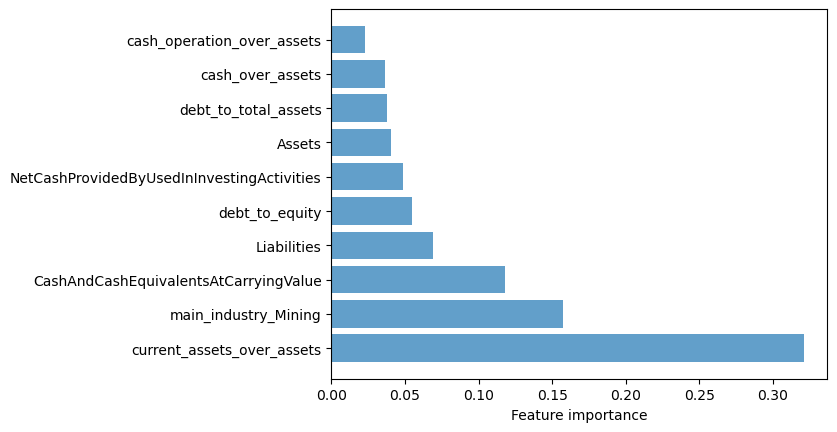

In [53]:
importances = smote_tree.best_estimator_.named_steps['model'].feature_importances_
indices = np.argsort(importances)[::-1][:10]
plt.barh(range(len(indices)), importances[indices], alpha = 0.7)
plt.yticks(range(len(indices)), X_train.columns[indices])
plt.xlabel("Feature importance")
plt.show()

# 3. SVM

In [54]:
param_grid = {
    'C': [10, 100, 1000],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf'] 
}

vsvm = SVC(random_state = 42, probability=True)
vsvm_gs = GridSearchCV(vsvm, param_grid, scoring = 'average_precision', cv = 5)
wsvm = SVC(class_weight = 'balanced', random_state = 42, probability=True)
wsvm_gs = GridSearchCV(wsvm, param_grid, scoring = 'average_precision', cv = 5)

vsvm_gs.fit(X_train_scaled, y_train)
wsvm_gs.fit(X_train_scaled, y_train)

# Output the best parameters and the best score
print("Best parameters for vanilla svm:", vsvm_gs.best_params_)
print("Best parameters for weighted data svm:", wsvm_gs.best_params_)

Best parameters for vanilla svm: {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
Best parameters for weighted data svm: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}


## 3.1 vanilla SVM

In [71]:
measure(vsvm_gs)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      9587
           1       0.27      1.00      0.42        46

    accuracy                           0.99      9633
   macro avg       0.63      0.99      0.71      9633
weighted avg       1.00      0.99      0.99      9633

Train Auc_roc: 0.9967256384324787
Train average precision: 0.41720968325330565
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      3186
           1       0.19      0.50      0.27        26

    accuracy                           0.98      3212
   macro avg       0.59      0.74      0.63      3212
weighted avg       0.99      0.98      0.98      3212

Test auc_roc: 0.9307849244289922
Test average precision: 0.28006059244714393


## 3.2. weighted data SVM

In [55]:
measure(wsvm_gs)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      7238
           1       0.36      1.00      0.53        45

    accuracy                           0.99      7283
   macro avg       0.68      0.99      0.76      7283
weighted avg       1.00      0.99      0.99      7283

Train Auc_roc: 0.9981501949587056
Train average precision: 0.6422468852407186
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2405
           1       0.14      0.30      0.19        23

    accuracy                           0.98      2428
   macro avg       0.57      0.64      0.59      2428
weighted avg       0.99      0.98      0.98      2428

Test auc_roc: 0.927614571092832
Test average precision: 0.1398164504034295


## 3.3. SMOTE + SVM

In [56]:
model = SVC(probability=True, random_state = 42)
under = RandomUnderSampler(sampling_strategy = 0.9, random_state = 42)
over = SMOTE(sampling_strategy = 0.5, random_state = 42)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps = steps)

parameters = {
    'model__C': [10, 100, 1000],
    'model__gamma': ['scale', 'auto'],
    'model__kernel': ['rbf'] 
}
smote_svm = GridSearchCV(
            pipeline,
            param_grid = parameters,
            scoring = 'average_precision',
            cv = 5)
smote_svm.fit(X_train_scaled, y_train)
print("Best parameters:", smote_svm.best_params_)
print("Best score:", smote_svm.best_score_)

Best parameters: {'model__C': 10, 'model__gamma': 'auto', 'model__kernel': 'rbf'}
Best score: 0.21174572776083284


In [57]:
measure(smote_svm)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      7238
           1       0.21      0.71      0.32        45

    accuracy                           0.98      7283
   macro avg       0.60      0.85      0.66      7283
weighted avg       0.99      0.98      0.99      7283

Train Auc_roc: 0.9756485830953915
Train average precision: 0.4358919552282028
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2405
           1       0.20      0.39      0.26        23

    accuracy                           0.98      2428
   macro avg       0.59      0.69      0.63      2428
weighted avg       0.99      0.98      0.98      2428

Test auc_roc: 0.9157732983819941
Test average precision: 0.2209916784404341


# 4. Easy Ensemble Classifier

In [58]:
eec = EasyEnsembleClassifier(random_state=42)

In [59]:
eec.fit(X_train_scaled, y_train)

EasyEnsembleClassifier(random_state=42)

In [60]:
measure(eec)

              precision    recall  f1-score   support

           0       1.00      0.85      0.92      7238
           1       0.04      1.00      0.08        45

    accuracy                           0.85      7283
   macro avg       0.52      0.93      0.50      7283
weighted avg       0.99      0.85      0.91      7283

Train Auc_roc: 0.9872816308986522
Train average precision: 0.3461356032109719
              precision    recall  f1-score   support

           0       1.00      0.85      0.92      2405
           1       0.05      0.83      0.09        23

    accuracy                           0.85      2428
   macro avg       0.52      0.84      0.51      2428
weighted avg       0.99      0.85      0.91      2428

Test auc_roc: 0.9431076561511343
Test average precision: 0.3045116464848375
